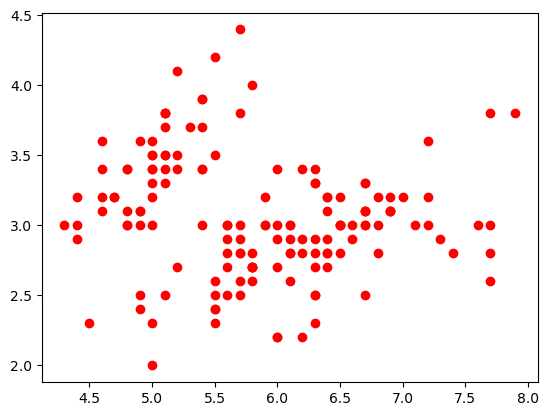

w [-5.6410942  -2.09317498 -5.03330731 -1.61814635]
b 55.77585203294773
predict [-1.  1. -1. -1. -1.  1. -1. -1. -1. -1. -1.  1.  1.  1.  1. -1. -1. -1.
 -1. -1.  1. -1.  1. -1. -1. -1. -1. -1.  1.  1.]
target [-1  1 -1 -1 -1  1 -1 -1 -1 -1 -1  1  1  1  1 -1 -1 -1 -1 -1  1 -1  1 -1
 -1 -1 -1 -1  1  1]
正确率: 100.00%


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


class SMO:

    def __init__(self, X, y, C, kernel, tol, max_passes=10):
        self.X = X
        self.y = y  
        self.C = C 
        self.kernel = kernel 
        self.tol = tol 
        self.max_passes = max_passes 
        self.m, self.n = X.shape
        self.alpha = np.zeros(self.m)
        self.b = 0
        self.w = np.zeros(self.n)

    def K(self, i, j):
        if self.kernel == 'linear':
            return np.dot(self.X[i].T, self.X[j])
        elif self.kernel == 'rbf':
            gamma = 0.5
            return np.exp(-gamma * np.linalg.norm(self.X[i] - self.X[j]) ** 2)

        else:
            raise ValueError('Invalid kernel specified')

    def predict(self, X):
        pred = np.zeros_like(X[:, 0])
        pred = np.dot(X_test, self.w) + self.b
        return np.sign(pred)

    def train(self):
        passes = 0
        while passes < self.max_passes:
            num_changed_alphas = 0
            for i in range(self.m):
                E_i = 0
                for ii in range(self.m):
                    E_i += self.alpha[ii] * self.y[ii] * self.K(ii, i)
                E_i += self.b - self.y[i]
                if (self.y[i] * E_i < -self.tol and self.alpha[i] < self.C) or (self.y[i] * E_i > self.tol and self.alpha[i] > 0):
                    j = np.random.choice(list(range(i)) + list(range(i + 1, self.m)), size=1)[0]
                    E_j = 0
                    for jj in range(self.m):
                        E_j += self.alpha[jj] * self.y[jj] * self.K(jj, j)
                    E_j += self.b - self.y[j]

                    alpha_i_old = self.alpha[i].copy()
                    alpha_j_old = self.alpha[j].copy()

                    
                    if self.y[i] != self.y[j]:
                        L = max(0, self.alpha[j] - self.alpha[i])
                        H = min(self.C, self.C + self.alpha[j] - self.alpha[i])
                    else:
                        L = max(0, self.alpha[i] + self.alpha[j] - self.C)
                        H = min(self.C, self.alpha[i] + self.alpha[j])
                    if L == H:
                        continue
                    eta = 2 * self.K(i, j) - self.K(i, i) - self.K(j, j)
                    if eta >= 0:
                        continue
                    self.alpha[j] -= (self.y[j] * (E_i - E_j)) / eta
                    self.alpha[j] = np.clip(self.alpha[j], L, H)
                    if abs(self.alpha[j] - alpha_j_old) < 1e-5:
                        continue
                    self.alpha[i] += self.y[i] * self.y[j] * (alpha_j_old - self.alpha[j])
                    b1 = self.b - E_i - self.y[i] * (self.alpha[i] - alpha_i_old) * self.K(i, i) \
                         - self.y[j] * (self.alpha[j] - alpha_j_old) * self.K(i, j)
                    b2 = self.b - E_j - self.y[i] * (self.alpha[i] - alpha_i_old) * self.K(i, j) \
                         - self.y[j] * (self.alpha[j] - alpha_j_old) * self.K(j, j)

                    if 0 < self.alpha[i] and self.alpha[i] < self.C:
                        self.b = b1
                    elif 0 < self.alpha[j] and self.alpha[j] < self.C:
                        self.b = b2
                    else:
                        self.b = (b1 + b2) / 2

                    num_changed_alphas += 1

            if num_changed_alphas == 0:
                passes += 1
            else:
                passes = 0

        idx = self.alpha > 0  
        selected_idx = np.where(idx)[0]
        SVs = X[selected_idx]
        SV_labels = y[selected_idx]
        SV_alphas = self.alpha[selected_idx]

        self.w = np.sum(SV_alphas[:, None] * SV_labels[:, None] * SVs, axis=0)
        self.b = np.mean(SV_labels - np.dot(SVs, self.w))
        print("w", self.w)
        print("b", self.b)

    def score(self, X, y):
        predict = self.predict(X)
        print("predict", predict)
        print("target", y)
        return np.mean(predict == y)


iris = datasets.load_iris()
X = iris.data
y = iris.target
y[y != 0] = -1
y[y == 0] = 1


plt.scatter(X[y != 0, 0], X[y != 0, 1], color='red')
plt.scatter(X[y == 0, 0], X[y == 0, 1], color='blue')
plt.show()


scaler = StandardScaler()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_std = scaler.fit_transform(X_train)


svm = SMO(X_train_std, y_train, C=0.6, kernel='linear', tol=0.001)
svm.train()



X_test_std = scaler.transform(X_test)
accuracy = svm.score(X_test_std, y_test)

print('正确率: {:.2%}'.format(accuracy))


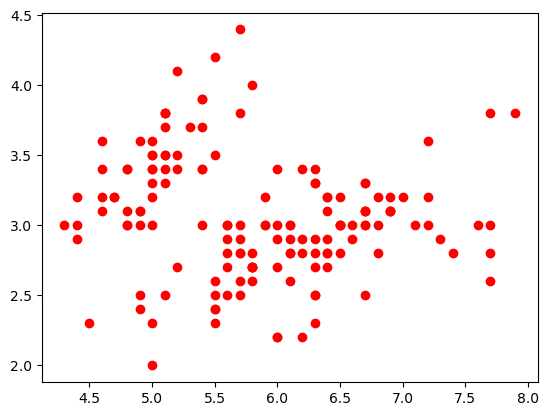

w [-4.70688869 -1.40513186 -4.23270513 -1.37273297]
b 53.65140102864009
predict [-1.  1.  1.  1. -1.  1. -1. -1. -1.  1.  1. -1.  1. -1.  1.  1. -1. -1.
  1. -1.  1. -1. -1.  1. -1.  1.  1. -1.  1. -1.]
target [-1  1 -1 -1 -1  1 -1 -1 -1 -1  1 -1  1 -1  1  1 -1 -1  1 -1 -1 -1 -1 -1
 -1 -1  1 -1  1 -1]
recall: 100.0 %
正确率: 80.00%


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


class SMO:

    def __init__(self, X, y, C, kernel, tol, max_passes=10):
        self.X = X  
        self.y = y  
        self.C = C 
        self.kernel = kernel 
        self.tol = tol  
        self.max_passes = max_passes  
        self.m, self.n = X.shape
        self.alpha = np.zeros(self.m)
        self.b = 0
        self.w = np.zeros(self.n)

    def K(self, i, j):
        if self.kernel == 'linear':
            return np.dot(self.X[i].T, self.X[j])
        elif self.kernel == 'rbf':
            gamma = 0.5
            return np.exp(-gamma * np.linalg.norm(self.X[i] - self.X[j]) ** 2)

        else:
            raise ValueError('Invalid kernel specified')

    def predict(self, X):
        pred = np.zeros_like(X[:, 0])
        pred = np.dot(X_test, self.w) + self.b
        return np.sign(pred)

    def train(self):
        passes = 0
        while passes < self.max_passes:
            num_changed_alphas = 0
            for i in range(self.m):
                E_i = 0
                for ii in range(self.m):
                    E_i += self.alpha[ii] * self.y[ii] * self.K(ii, i)
                E_i += self.b - self.y[i]
                if (self.y[i] * E_i < -self.tol and self.alpha[i] < self.C) or (self.y[i] * E_i > self.tol and self.alpha[i] > 0):
                    j = np.random.choice(list(range(i)) + list(range(i + 1, self.m)), size=1)[0]
                    E_j = 0
                    for jj in range(self.m):
                        E_j += self.alpha[jj] * self.y[jj] * self.K(jj, j)
                    E_j += self.b - self.y[j]

                    alpha_i_old = self.alpha[i].copy()
                    alpha_j_old = self.alpha[j].copy()
                    if self.y[i] != self.y[j]:
                        L = max(0, self.alpha[j] - self.alpha[i])
                        H = min(self.C, self.C + self.alpha[j] - self.alpha[i])
                    else:
                        L = max(0, self.alpha[i] + self.alpha[j] - self.C)
                        H = min(self.C, self.alpha[i] + self.alpha[j])
                    if L == H:
                        continue
                    eta = 2 * self.K(i, j) - self.K(i, i) - self.K(j, j)
                    if eta >= 0:
                        continue
                    self.alpha[j] -= (self.y[j] * (E_i - E_j)) / eta
                    self.alpha[j] = np.clip(self.alpha[j], L, H)
                    if abs(self.alpha[j] - alpha_j_old) < 1e-5:
                        continue
                    self.alpha[i] += self.y[i] * self.y[j] * (alpha_j_old - self.alpha[j])
                    b1 = self.b - E_i - self.y[i] * (self.alpha[i] - alpha_i_old) * self.K(i, i) \
                         - self.y[j] * (self.alpha[j] - alpha_j_old) * self.K(i, j)
                    b2 = self.b - E_j - self.y[i] * (self.alpha[i] - alpha_i_old) * self.K(i, j) \
                         - self.y[j] * (self.alpha[j] - alpha_j_old) * self.K(j, j)
                    if 0 < self.alpha[i] and self.alpha[i] < self.C:
                        self.b = b1
                    elif 0 < self.alpha[j] and self.alpha[j] < self.C:
                        self.b = b2
                    else:
                        self.b = (b1 + b2) / 2

                    num_changed_alphas += 1

            if num_changed_alphas == 0:
                passes += 1
            else:
                passes = 0

        idx = self.alpha > 0 
        # SVs = X[idx]
        selected_idx = np.where(idx)[0]
        SVs = X[selected_idx]
        SV_labels = y[selected_idx]
        SV_alphas = self.alpha[selected_idx]

        self.w = np.sum(SV_alphas[:, None] * SV_labels[:, None] * SVs, axis=0)
        self.b = np.mean(SV_labels - np.dot(SVs, self.w))
        print("w", self.w)
        print("b", self.b)

    def score(self, X, y):
        predict = self.predict(X)
        print("predict", predict)
        print("target", y)
        
        lenn=len(y)
        a=0
        b=0
        for i in range(0,lenn):
            if y[i]==1:
                b+=1
                if(predict[i]==1):
                    a+=1
        print('recall:',a/b*100,"%")
        
        return np.mean(predict == y)


iris = datasets.load_iris()
X = iris.data
y = iris.target
y[y != 0] = -1
y[y == 0] = 1

plt.scatter(X[y != 0, 0], X[y != 0, 1], color='red')
plt.scatter(X[y == 0, 0], X[y == 0, 1], color='blue')
plt.show()

scaler = StandardScaler()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=44)
X_train_std = scaler.fit_transform(X_train)
svm = SMO(X_train_std, y_train, C=0.6, kernel='linear', tol=0.001)
svm.train()

X_test_std = scaler.transform(X_test)
accuracy = svm.score(X_test_std, y_test)

print('正确率: {:.2%}'.format(accuracy))


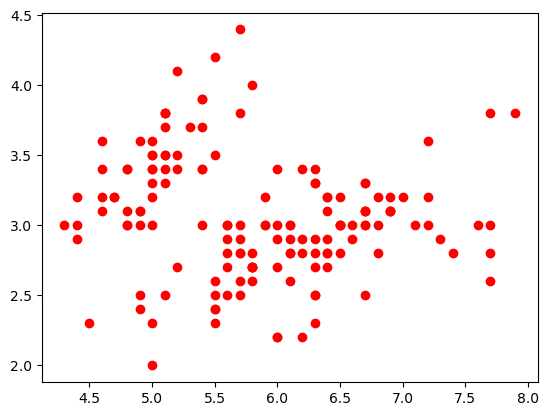

w [-5.11084736 -1.67575795 -4.53149665 -1.42118314]
b 59.18505236443465
predict [-1.  1.  1.  1. -1.  1. -1. -1. -1.  1.  1. -1.  1. -1.  1.  1. -1. -1.
  1. -1.  1. -1. -1.  1. -1.  1.  1. -1.  1. -1.]
target [-1  1 -1 -1 -1  1 -1 -1 -1 -1  1 -1  1 -1  1  1 -1 -1  1 -1 -1 -1 -1 -1
 -1 -1  1 -1  1 -1]
recall: 100.0 %
正确率: 80.00%
F1 score: 0.888888888888889


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


class SMO:

    def __init__(self, X, y, C, kernel, tol, max_passes=10):
        self.X = X
        self.y = y
        self.C = C 
        self.kernel = kernel  
        self.tol = tol
        self.max_passes = max_passes 
        self.m, self.n = X.shape
        self.alpha = np.zeros(self.m)
        self.b = 0
        self.w = np.zeros(self.n)

    def K(self, i, j):
        if self.kernel == 'linear':
            return np.dot(self.X[i].T, self.X[j])
        elif self.kernel == 'rbf':
            gamma = 0.5
            return np.exp(-gamma * np.linalg.norm(self.X[i] - self.X[j]) ** 2)

        else:
            raise ValueError('Invalid kernel specified')

    def predict(self, X):
        pred = np.zeros_like(X[:, 0])
        pred = np.dot(X_test, self.w) + self.b
        return np.sign(pred)

    def train(self):
        passes = 0
        while passes < self.max_passes:
            num_changed_alphas = 0
            for i in range(self.m):
                E_i = 0
                for ii in range(self.m):
                    E_i += self.alpha[ii] * self.y[ii] * self.K(ii, i)
                E_i += self.b - self.y[i]
                if (self.y[i] * E_i < -self.tol and self.alpha[i] < self.C) or (self.y[i] * E_i > self.tol and self.alpha[i] > 0):
                    j = np.random.choice(list(range(i)) + list(range(i + 1, self.m)), size=1)[0]
                    E_j = 0
                    for jj in range(self.m):
                        E_j += self.alpha[jj] * self.y[jj] * self.K(jj, j)
                    E_j += self.b - self.y[j]

                    alpha_i_old = self.alpha[i].copy()
                    alpha_j_old = self.alpha[j].copy()
                    if self.y[i] != self.y[j]:
                        L = max(0, self.alpha[j] - self.alpha[i])
                        H = min(self.C, self.C + self.alpha[j] - self.alpha[i])
                    else:
                        L = max(0, self.alpha[i] + self.alpha[j] - self.C)
                        H = min(self.C, self.alpha[i] + self.alpha[j])
                    if L == H:
                        continue
                    eta = 2 * self.K(i, j) - self.K(i, i) - self.K(j, j)
                    if eta >= 0:
                        continue
                    self.alpha[j] -= (self.y[j] * (E_i - E_j)) / eta
                    self.alpha[j] = np.clip(self.alpha[j], L, H)
                    if abs(self.alpha[j] - alpha_j_old) < 1e-5:
                        continue
                    self.alpha[i] += self.y[i] * self.y[j] * (alpha_j_old - self.alpha[j])
                    b1 = self.b - E_i - self.y[i] * (self.alpha[i] - alpha_i_old) * self.K(i, i) \
                         - self.y[j] * (self.alpha[j] - alpha_j_old) * self.K(i, j)
                    b2 = self.b - E_j - self.y[i] * (self.alpha[i] - alpha_i_old) * self.K(i, j) \
                         - self.y[j] * (self.alpha[j] - alpha_j_old) * self.K(j, j)
                    if 0 < self.alpha[i] and self.alpha[i] < self.C:
                        self.b = b1
                    elif 0 < self.alpha[j] and self.alpha[j] < self.C:
                        self.b = b2
                    else:
                        self.b = (b1 + b2) / 2

                    num_changed_alphas += 1

            if num_changed_alphas == 0:
                passes += 1
            else:
                passes = 0

        idx = self.alpha > 0 
        # SVs = X[idx]
        selected_idx = np.where(idx)[0]
        SVs = X[selected_idx]
        SV_labels = y[selected_idx]
        SV_alphas = self.alpha[selected_idx]
        self.w = np.sum(SV_alphas[:, None] * SV_labels[:, None] * SVs, axis=0)
        self.b = np.mean(SV_labels - np.dot(SVs, self.w))
        print("w", self.w)
        print("b", self.b)

    def score(self, X, y):
        predict = self.predict(X)
        print("predict", predict)
        print("target", y)
        
        lenn=len(y)
        a=0
        b=0
        for i in range(0,lenn):
            if y[i]==1:
                b+=1
                if(predict[i]==1):
                    a+=1
        print('recall:',a/b*100,"%")
        
        return np.mean(predict == y),a/b 


iris = datasets.load_iris()
X = iris.data
y = iris.target
y[y != 0] = -1
y[y == 0] = 1

plt.scatter(X[y != 0, 0], X[y != 0, 1], color='red')
plt.scatter(X[y == 0, 0], X[y == 0, 1], color='blue')
plt.show()

scaler = StandardScaler()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=44)
X_train_std = scaler.fit_transform(X_train)

svm = SMO(X_train_std, y_train, C=0.6, kernel='linear', tol=0.001)
svm.train()

X_test_std = scaler.transform(X_test)
accuracy,x = svm.score(X_test_std, y_test)

print('正确率: {:.2%}'.format(accuracy))
print('F1 score:',2*x*accuracy/(x+accuracy))


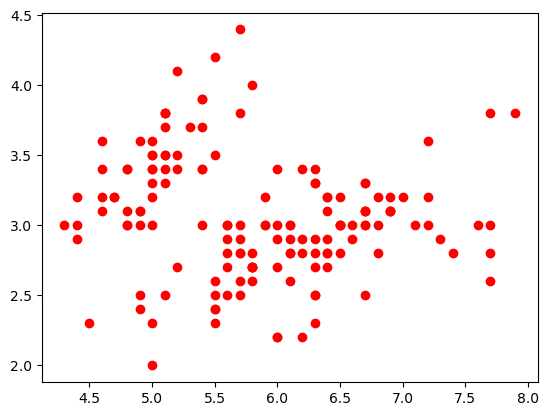

w [-4.59506289 -1.40785781 -4.19162621 -1.36240164]
b 52.21395575393391
predict [-1.  1.  1.  1. -1.  1. -1. -1. -1.  1.  1. -1.  1. -1.  1.  1. -1. -1.
  1. -1.  1. -1. -1.  1. -1.  1.  1. -1.  1. -1.]
target [-1  1 -1 -1 -1  1 -1 -1 -1 -1  1 -1  1 -1  1  1 -1 -1  1 -1 -1 -1 -1 -1
 -1 -1  1 -1  1 -1]
recall: 100.0 %
      真实值
      P   N
预 P  9   6
测 N  0   15
值
正确率: 80.00%
F1 score: 0.888888888888889


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


class SMO:

    def __init__(self, X, y, C, kernel, tol, max_passes=10):
        self.X = X 
        self.y = y  
        self.C = C 
        self.kernel = kernel  
        self.tol = tol 
        self.max_passes = max_passes 
        self.m, self.n = X.shape
        self.alpha = np.zeros(self.m)
        self.b = 0
        self.w = np.zeros(self.n)

    def K(self, i, j):
        if self.kernel == 'linear':
            return np.dot(self.X[i].T, self.X[j])
        elif self.kernel == 'rbf':
            gamma = 0.5
            return np.exp(-gamma * np.linalg.norm(self.X[i] - self.X[j]) ** 2)

        else:
            raise ValueError('Invalid kernel specified')

    def predict(self, X):
        pred = np.zeros_like(X[:, 0])
        pred = np.dot(X_test, self.w) + self.b
        return np.sign(pred)

    def train(self):
        passes = 0
        while passes < self.max_passes:
            num_changed_alphas = 0
            for i in range(self.m):
                E_i = 0
                for ii in range(self.m):
                    E_i += self.alpha[ii] * self.y[ii] * self.K(ii, i)
                E_i += self.b - self.y[i]
                if (self.y[i] * E_i < -self.tol and self.alpha[i] < self.C) or (self.y[i] * E_i > self.tol and self.alpha[i] > 0):
                    j = np.random.choice(list(range(i)) + list(range(i + 1, self.m)), size=1)[0]
                    E_j = 0
                    for jj in range(self.m):
                        E_j += self.alpha[jj] * self.y[jj] * self.K(jj, j)
                    E_j += self.b - self.y[j]

                    alpha_i_old = self.alpha[i].copy()
                    alpha_j_old = self.alpha[j].copy()

                    if self.y[i] != self.y[j]:
                        L = max(0, self.alpha[j] - self.alpha[i])
                        H = min(self.C, self.C + self.alpha[j] - self.alpha[i])
                    else:
                        L = max(0, self.alpha[i] + self.alpha[j] - self.C)
                        H = min(self.C, self.alpha[i] + self.alpha[j])
                    if L == H:
                        continue
                    eta = 2 * self.K(i, j) - self.K(i, i) - self.K(j, j)
                    if eta >= 0:
                        continue
                    self.alpha[j] -= (self.y[j] * (E_i - E_j)) / eta
                    self.alpha[j] = np.clip(self.alpha[j], L, H)
                    if abs(self.alpha[j] - alpha_j_old) < 1e-5:
                        continue
                    self.alpha[i] += self.y[i] * self.y[j] * (alpha_j_old - self.alpha[j])
                    b1 = self.b - E_i - self.y[i] * (self.alpha[i] - alpha_i_old) * self.K(i, i) \
                         - self.y[j] * (self.alpha[j] - alpha_j_old) * self.K(i, j)
                    b2 = self.b - E_j - self.y[i] * (self.alpha[i] - alpha_i_old) * self.K(i, j) \
                         - self.y[j] * (self.alpha[j] - alpha_j_old) * self.K(j, j)
                    if 0 < self.alpha[i] and self.alpha[i] < self.C:
                        self.b = b1
                    elif 0 < self.alpha[j] and self.alpha[j] < self.C:
                        self.b = b2
                    else:
                        self.b = (b1 + b2) / 2

                    num_changed_alphas += 1

            if num_changed_alphas == 0:
                passes += 1
            else:
                passes = 0
        idx = self.alpha > 0  
        selected_idx = np.where(idx)[0]
        SVs = X[selected_idx]
        SV_labels = y[selected_idx]
        SV_alphas = self.alpha[selected_idx]
        self.w = np.sum(SV_alphas[:, None] * SV_labels[:, None] * SVs, axis=0)
        self.b = np.mean(SV_labels - np.dot(SVs, self.w))
        print("w", self.w)
        print("b", self.b)

    def score(self, X, y):
        predict = self.predict(X)
        print("predict", predict)
        print("target", y)
        
        lenn=len(y)
        aa=0
        bb=0
        for i in range(0,lenn):
            if y[i]==1:
                bb+=1
                if(predict[i]==1):
                    aa+=1
        print('recall:',aa/bb*100,"%")

        a=0
        b=0
        c=0
        d=0
        for i in range(0,lenn):
            if y[i]==1 and predict[i]==1:
                a+=1
            elif y[i]==-1 and predict[i]==1:
                b+=1
            elif y[i]==1 and predict[i]==-1:
                c+=1
            elif y[i]==-1 and predict[i]==-1:
                d+=1
        print('      真实值')
        print('      P   N')
        print('预 P ',a,' ',b)
        print('测 N ',c,' ',d)
        print('值')
        return np.mean(predict == y),aa/bb 


iris = datasets.load_iris()
X = iris.data
y = iris.target
y[y != 0] = -1
y[y == 0] = 1
plt.scatter(X[y != 0, 0], X[y != 0, 1], color='red')
plt.scatter(X[y == 0, 0], X[y == 0, 1], color='blue')
plt.show()

scaler = StandardScaler()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=44)
X_train_std = scaler.fit_transform(X_train)
svm = SMO(X_train_std, y_train, C=0.6, kernel='linear', tol=0.001)
svm.train()
X_test_std = scaler.transform(X_test)
accuracy,x = svm.score(X_test_std, y_test)

print('正确率: {:.2%}'.format(accuracy))
print('F1 score:',2*x*accuracy/(x+accuracy))



In [1]:
from sklearn.datasets import fetch_20newsgroups
twenty_train = fetch_20newsgroups(subset='train')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC

vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(twenty_train.data)
y_train = twenty_train.target

model = SVC(kernel='rbf')
model.fit(X_train, y_train)


SVC()

In [3]:
import numpy as np
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC



newsgroups = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))
X_train, X_test, y_train, y_test = train_test_split(newsgroups.data, newsgroups.target, test_size=0.2, random_state=42)
clf = make_pipeline(TfidfVectorizer(), MultinomialNB())
clf.fit(X_train, y_train)

predicted = clf.predict(X_test)
print(classification_report(y_test, predicted, target_names=newsgroups.target_names))

                          precision    recall  f1-score   support

             alt.atheism       0.86      0.12      0.21       151
           comp.graphics       0.70      0.61      0.66       202
 comp.os.ms-windows.misc       0.67      0.61      0.64       195
comp.sys.ibm.pc.hardware       0.52      0.78      0.62       183
   comp.sys.mac.hardware       0.89      0.64      0.74       205
          comp.windows.x       0.89      0.81      0.85       215
            misc.forsale       0.86      0.60      0.71       193
               rec.autos       0.85      0.73      0.79       196
         rec.motorcycles       0.51      0.74      0.61       168
      rec.sport.baseball       0.96      0.77      0.86       211
        rec.sport.hockey       0.88      0.88      0.88       198
               sci.crypt       0.63      0.83      0.71       201
         sci.electronics       0.85      0.55      0.67       202
                 sci.med       0.88      0.69      0.77       194
         

In [4]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, predicted)
print(conf_mat)

[[ 18   0   0   0   0   0   0   1   5   2   1   4   0   2   2 106   0  10
    0   0]
 [  0 124  14  17   0   8   1   0   7   0   1   7   0   0   3  18   0   2
    0   0]
 [  0  11 118  31   2   7   0   0   9   0   0   7   0   0   0  10   0   0
    0   0]
 [  0   6  16 142   3   0   3   0   1   0   0   3   2   1   0   6   0   0
    0   0]
 [  0   2   5  29 131   0   3   1  12   0   0   8   2   2   2   7   1   0
    0   0]
 [  0  14   9   3   1 174   0   1   2   0   1   3   0   0   2   5   0   0
    0   0]
 [  0   3   2  28   7   2 116   6   3   0   0   6   5   2   3   9   1   0
    0   0]
 [  0   0   0   0   1   1   2 143  12   0   2   6   3   1   2  20   2   1
    0   0]
 [  0   2   0   1   0   1   5   5 125   2   1   2   1   2   2  18   1   0
    0   0]
 [  0   0   0   0   0   1   0   0  10 163   9   2   0   0   0  25   0   1
    0   0]
 [  0   1   0   0   0   0   0   1   7   0 174   1   0   1   0  13   0   0
    0   0]
 [  0   3   3   0   0   1   0   0   2   0   2 167   0   0   3  15

E:\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
E:\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


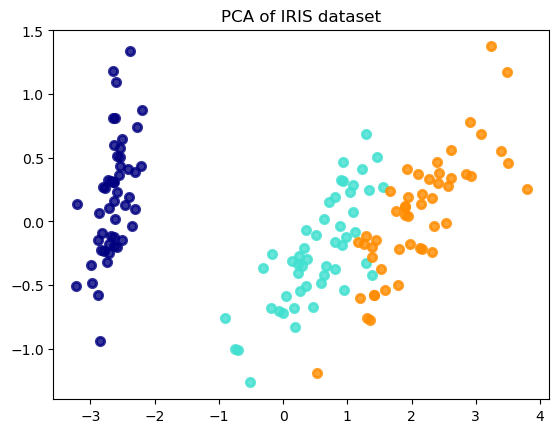

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
 
iris = load_iris()
X = iris.data

kmeans=KMeans(n_clusters=3)
kmeans.fit(X)
y_kmeans=kmeans.predict(X)

y = iris.target
target_names = iris.target_names
 
pca=PCA(n_components=2)
X_r=pca.fit_transform(X)
var=pca.explained_variance_ratio_
_cumvar=np.cumsum(var)
 
plt.figure()
colors = ["navy", "turquoise", "darkorange"] 
for color, i, target_name in zip(colors, [0, 1, 2], target_names):
    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=0.8, lw=2, label=target_name)
plt.title("PCA of IRIS dataset")
plt.show()

E:\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
E:\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


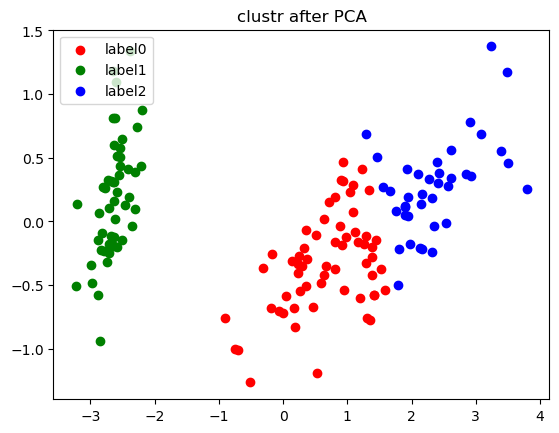

In [13]:
pca_kmeans=KMeans(n_clusters=3)
pca_kmeans.fit(X_r)
y_pca_kmeans=pca_kmeans.predict(X_r)
x0_pca = X_r[y_pca_kmeans == 0]
x1_pca = X_r[y_pca_kmeans == 1]
x2_pca = X_r[y_pca_kmeans == 2]
plt.figure()
plt.scatter(x0_pca[:, 0], x0_pca[:, 1], c="red", marker='o', label='label0')
plt.scatter(x1_pca[:, 0], x1_pca[:, 1], c="green", marker='o', label='label1')
plt.scatter(x2_pca[:, 0], x2_pca[:, 1], c="blue", marker='o', label='label2')
plt.title("clustr after PCA")
plt.legend(loc=2)
plt.show()

E:\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
E:\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
E:\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
E:\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


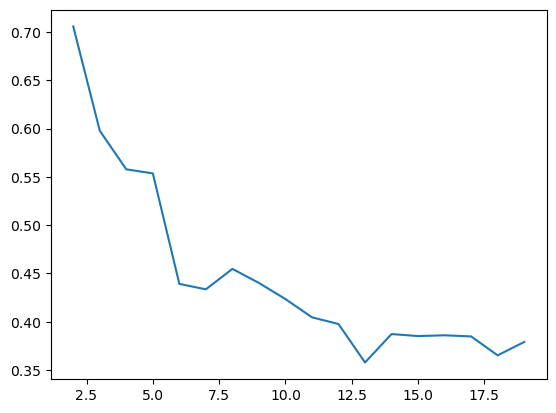

In [14]:
from sklearn.metrics import silhouette_score

XX=[]
YY=[]

for n in range(2, 20):
    XX.append(n)
    cluster = KMeans(n_clusters=n,random_state=10).fit(X_r)
    y_pred = cluster.labels_
    centroid = cluster.cluster_centers_
    silhouette_avg = silhouette_score(X_r, y_pred)
    YY.append(silhouette_avg)

plt.plot(XX,YY)
plt.show()